In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\johns\AppData\Local\Temp\ipykernel_21716\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['station', 'measurement']


In [8]:
# Save references to each table

# Save references to each table
tables = {}
for table_name, table_class in Base.classes.items():
    tables[table_name] = table_class

# Access the tables by name
station_table = tables.get('station')
measurement_table = tables.get('measurement')

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
from sqlalchemy import func

# Query to find the most recent date in the dataset
most_recent_date = session.query(func.max(measurement_table.date)).scalar()

print("The most recent date in the dataset is:", most_recent_date)

The most recent date in the dataset is: 2017-08-23


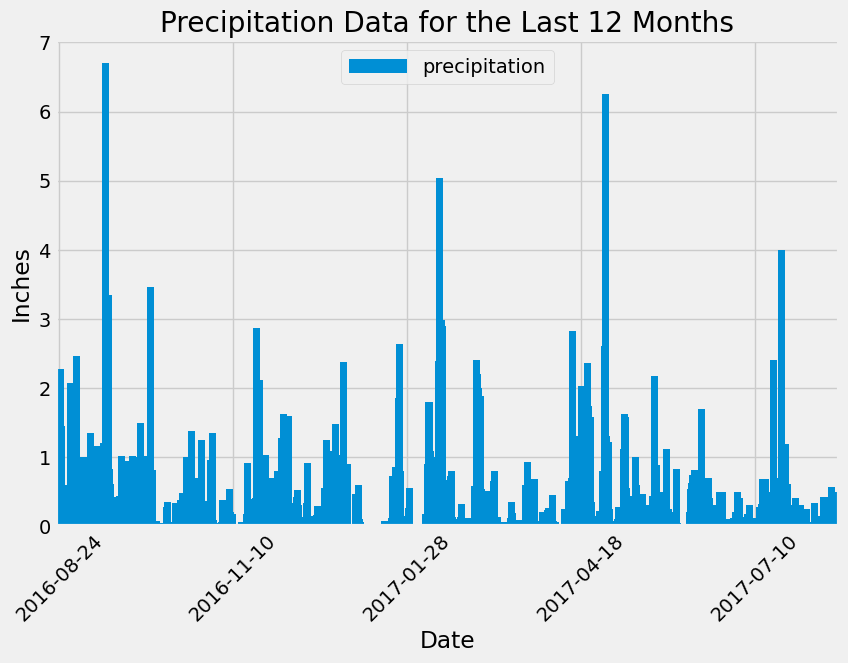

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(months=12)

# Perform a query to retrieve the data and precipitation scores
query = f"SELECT date, prcp FROM measurement WHERE date >= '{one_year_ago}'"

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data = pd.read_sql(query, engine)

# Sort the dataframe by date
precipitation_data = precipitation_data.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
#plt.figure(figsize=(12, 6))
precipitation_data.plot(x='date', y='prcp', kind='bar', width=20,figsize=(9, 6))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(498))
plt.xlabel('Date')
plt.ylabel('Inches')
legend=plt.legend(['precipitation'], loc='upper center',
                  ncol=1, handlelength=3.0) 
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=45)
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Calculate summary statistics for the precipitation data
summary_stats = precipitation_data['prcp'].describe()

# Print the summary statistics
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
# Access the station table
Station = Base.classes.station
Measurement = Base.classes.measurement

# Create a session
session = Session(engine)

# Query to calculate the total number of stations
total_stations = session.query(Station).count()

total_stations

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to find the most active stations and their observation counts in descending order
active_stations = session.query(Station.station, func.count(Measurement.id).label('observation_count')) \
                    .join(Measurement, Station.station == Measurement.station) \
                    .group_by(Station.station) \
                    .order_by(func.count(Measurement.id).desc())

# Print the results
for station, count in active_stations:
    print(f"Station: {station}, Observation Count: {count}")

Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

results = session.query(
    func.min(Measurement.tobs).label('min_temperature'),
    func.max(Measurement.tobs).label('max_temperature'),
    func.avg(Measurement.tobs).label('avg_temperature')
).filter(Measurement.station == 'USC00519281').all()

# Extracting the results
for result in results:
    min_temperature = result.min_temperature
    max_temperature = result.max_temperature
    avg_temperature = result.avg_temperature

print(f"Lowest Temperature: {min_temperature}")
print(f"Highest Temperature: {max_temperature}")
print(f"Average Temperature: {avg_temperature}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


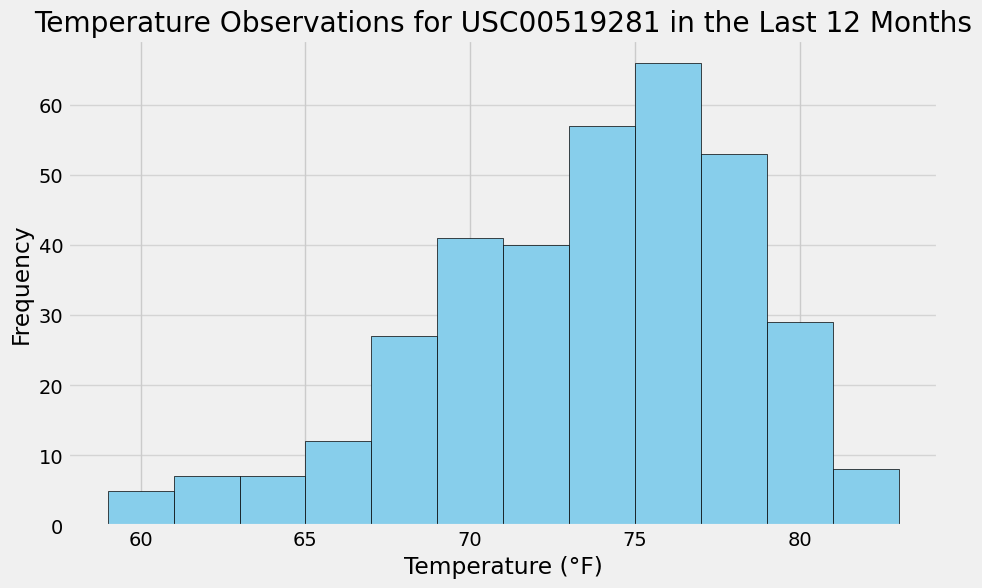

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

from sqlalchemy import func, and_, bindparam # Import the 'and_' function from SQLAlchemy
from datetime import datetime, timedelta
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')  # Convert to string in 'YYYY-MM-DD' format

results = session.query(Measurement.date, Measurement.tobs).filter(and_(Measurement.station == 'USC00519281', Measurement.date >= one_year_ago_str)).all()

# Create a DataFrame from the query results
df = pd.DataFrame(results, columns=['Date', 'Temperature'])
df.set_index('Date', inplace=True)

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for USC00519281 in the Last 12 Months')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()